In [59]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.feature_selection import mutual_info_classif
from xgboost import XGBClassifier

# Ignore all warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("pseudocells_cd4tem.csv")
X = df.drop(columns=['disease', 'donor_id'])
y = df['disease']

# Encode target variable
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Train-test split (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded,  random_state=42)

# Further split the 80% training data into training and validation (70:30 split ratio)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=42)

# Step 1: Calculate Mutual Information scores
mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
mi_scores = pd.Series(mi_scores, index=X_train.columns)
mi_scores = mi_scores.sort_values(ascending=False)

# Step 2: Train XGBoost and get feature importance
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_importance = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
xgb_importance = xgb_importance.sort_values(ascending=False)

# Step 3: Combine MI and XGBoost importance scores
# Normalize scores to the same scale (0 to 1)
mi_scores_normalized = (mi_scores - mi_scores.min()) / (mi_scores.max() - mi_scores.min())
xgb_importance_normalized = (xgb_importance - xgb_importance.min()) / (xgb_importance.max() - xgb_importance.min())

# Combine scores (you can adjust the weights as needed)
combined_scores = (mi_scores_normalized + xgb_importance_normalized) / 2
combined_scores = combined_scores.sort_values(ascending=False)

# Step 4: Forward feature selection based on combined scores
selected_features = []  # List to store selected features
roc_auc_by_feature_number = []  # List to store ROC-AUC scores
available_features = list(combined_scores.index)  # Features sorted by combined scores

# Forward feature selection based on ROC-AUC
for i in range(len(available_features)):
    if len(selected_features) >= 15:  # Stop if 25 features are selected
        break
    
    best_auc = 0
    best_feature = None
    
    # Iterate over remaining features
    for feature in available_features:
        # Create a temporary list of features including the current selected features and the new feature
        features_to_use = selected_features + [feature]
        
        # Train model using the selected features
        model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
        model.fit(X_train[features_to_use], y_train)
        
        # Get predicted probabilities
        y_probs = model.predict_proba(X_val[features_to_use])[:, 1]
        
        # Calculate ROC-AUC
        fpr, tpr, _ = roc_curve(y_val, y_probs)
        feature_auc = auc(fpr, tpr)
        
        # Update best feature and AUC score
        if feature_auc > best_auc:
            best_auc = feature_auc
            best_feature = feature
    
    # Add the best feature to the selected features list
    selected_features.append(best_feature)
    available_features.remove(best_feature)
    roc_auc_by_feature_number.append(best_auc)
    
    print(f'Step {i+1}: Added feature "{best_feature}" with AUC = {best_auc:.3f}')
    
# Final selected features
print("Final selected features:", selected_features)

Step 1: Added feature "ENSG00000266028" with AUC = 0.807
Step 2: Added feature "ENSG00000143851" with AUC = 0.857
Step 3: Added feature "ENSG00000269937" with AUC = 0.883
Step 4: Added feature "ENSG00000176542" with AUC = 0.912
Step 5: Added feature "ENSG00000124813" with AUC = 0.944
Step 6: Added feature "ENSG00000185818" with AUC = 0.944
Step 7: Added feature "ENSG00000248991" with AUC = 0.944
Step 8: Added feature "ENSG00000262097" with AUC = 0.944
Step 9: Added feature "ENSG00000133789" with AUC = 0.941
Step 10: Added feature "ENSG00000172936" with AUC = 0.948
Step 11: Added feature "ENSG00000174606" with AUC = 0.957
Step 12: Added feature "ENSG00000148180" with AUC = 0.964
Step 13: Added feature "ENSG00000155307" with AUC = 0.976
Step 14: Added feature "ENSG00000155367" with AUC = 0.976
Step 15: Added feature "ENSG00000135540" with AUC = 0.973
Final selected features: ['ENSG00000266028', 'ENSG00000143851', 'ENSG00000269937', 'ENSG00000176542', 'ENSG00000124813', 'ENSG00000185818',

In [60]:
y.value_counts()

normal                  333
rheumatoid arthritis    231
Name: disease, dtype: int64

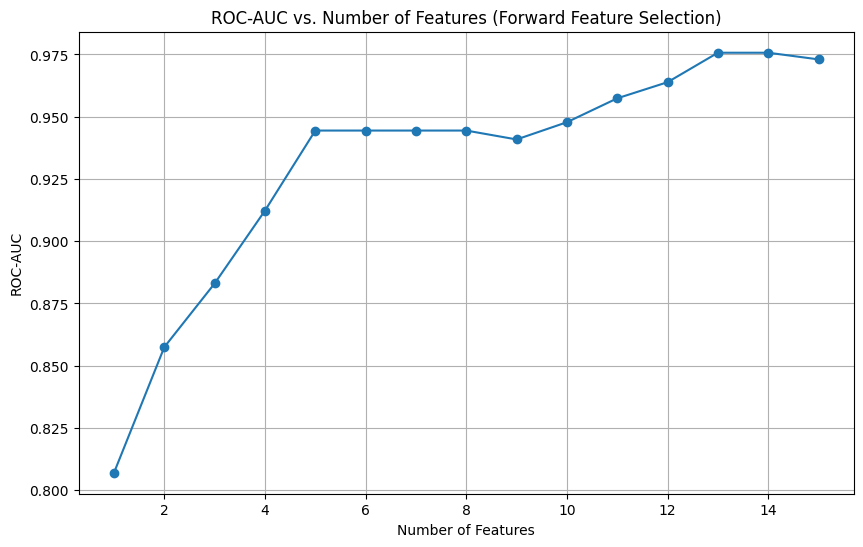

In [61]:
# Plot ROC-AUC vs. number of features
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(roc_auc_by_feature_number) + 1), roc_auc_by_feature_number, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC vs. Number of Features (Forward Feature Selection)')
plt.grid(True)
plt.show()

In [2]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.feature_selection import mutual_info_classif
from xgboost import XGBClassifier

# Load dataset
df = pd.read_csv("pseudocells_cd4tem.csv")
# Select columns (ensure they exist in the DataFrame)
columns_to_select = ['ENSG00000266028', 'ENSG00000143851', 'ENSG00000269937', 'ENSG00000176542', 'ENSG00000124813', 'ENSG00000185818', 'ENSG00000248991', 
                     'ENSG00000262097', 'ENSG00000133789', 'ENSG00000172936', 'ENSG00000174606', 'ENSG00000148180', 'ENSG00000155307', 'ENSG00000155367']
existing_columns = [col for col in columns_to_select if col in df.columns]
X = df[existing_columns]
y = df['disease']

# Encode target variable
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Train-test split (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded,  random_state=42)

# Further split the 80% training data into training and validation (70:30 split ratio)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train, random_state=42)

/opt/software/python/lib/python3.8/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [3]:
unique_classes, counts = np.unique(y_train, return_counts=True)
for cls, count in zip(unique_classes, counts):
    print(f"Class {encoder.classes_[cls]}: {count} samples")

Class normal: 186 samples
Class rheumatoid arthritis: 129 samples


In [39]:
import xgboost as xgb
# Train final model using 9 selected features
final_model = xgb.XGBClassifier(n_estimators=2000, early_stopping_rounds=20, learning_rate=0.0085,
                                colsample_bytree= 0.63, max_depth= 2, min_child_weight= 5, reg_alpha= 1, subsample= 0.65,
                                eval_metric='logloss', random_state=42)

final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train,),(X_test, y_test)],
    verbose=50
)

[0]	validation_0-logloss:0.67515	validation_1-logloss:0.67405
[50]	validation_0-logloss:0.61198	validation_1-logloss:0.61687
[100]	validation_0-logloss:0.57228	validation_1-logloss:0.58152
[150]	validation_0-logloss:0.54379	validation_1-logloss:0.55776
[200]	validation_0-logloss:0.52320	validation_1-logloss:0.54377
[250]	validation_0-logloss:0.50770	validation_1-logloss:0.53488
[300]	validation_0-logloss:0.49394	validation_1-logloss:0.52886
[350]	validation_0-logloss:0.48326	validation_1-logloss:0.52443
[400]	validation_0-logloss:0.47381	validation_1-logloss:0.52149
[450]	validation_0-logloss:0.46540	validation_1-logloss:0.51820
[500]	validation_0-logloss:0.45774	validation_1-logloss:0.51617
[550]	validation_0-logloss:0.45011	validation_1-logloss:0.51376
[600]	validation_0-logloss:0.44355	validation_1-logloss:0.51260
[608]	validation_0-logloss:0.44235	validation_1-logloss:0.51261


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.63, device=None, early_stopping_rounds=20,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.0085, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=2000,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

588

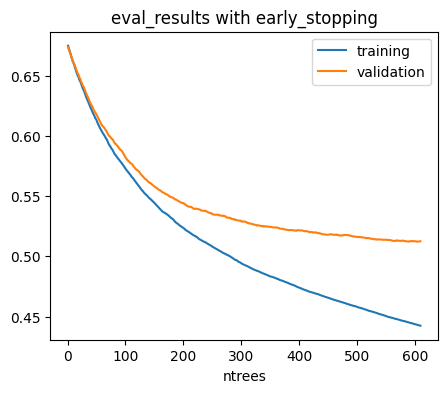

In [41]:
results = final_model.evals_result()
best_tree = final_model.best_iteration
fig, ax = plt.subplots(figsize=(8,4))
ax = (pd.DataFrame({'training':results['validation_0']['logloss'],
                    'validation': results['validation_1']['logloss']})
      .assign(ntrees=lambda adf: range(1, len(adf)+1))
    .set_index('ntrees')
    .plot(figsize=(5,4), ax=ax,
    title='eval_results with early_stopping')

)
ax.annotate(f'Best number \nof trees ({best_tree})', xy=(1607, 0.40938),
xytext=(400,.585), arrowprops={'color':'k'})
ax.set_xlabel('ntrees')
final_model.best_iteration

In [134]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier

param = {
    'n_estimators': [430],
    'learning_rate': [0.008],
    'max_depth':[2],
    'subsample': [0.5],
    'colsample_bytree': [0.63] ,
    'reg_alpha': [2],
    'min_child_weight': [5]
}
xgb_tuned = XGBClassifier(random_state=42)
best_xgb = GridSearchCV(
    estimator=xgb_tuned,
    param_grid=param,
    cv=StratifiedKFold(n_splits=5),  # Use stratified k-fold for imbalanced data
    scoring='roc_auc',  # Use 'roc_auc' or 'f1' for imbalanced data
    n_jobs=-1  # Use all available CPU cores
)
best_xgb.fit(X_train, y_train, 
             eval_set=[(X_train, y_train,),(X_val, y_val)],
            verbose = False)
print("Best accuracy: ", best_xgb.best_score_)
print("Best hyperparameters: ", best_xgb.best_params_)

Best accuracy:  0.7752611883138198
Best hyperparameters:  {'colsample_bytree': 0.63, 'learning_rate': 0.008, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 430, 'reg_alpha': 2, 'subsample': 0.5}


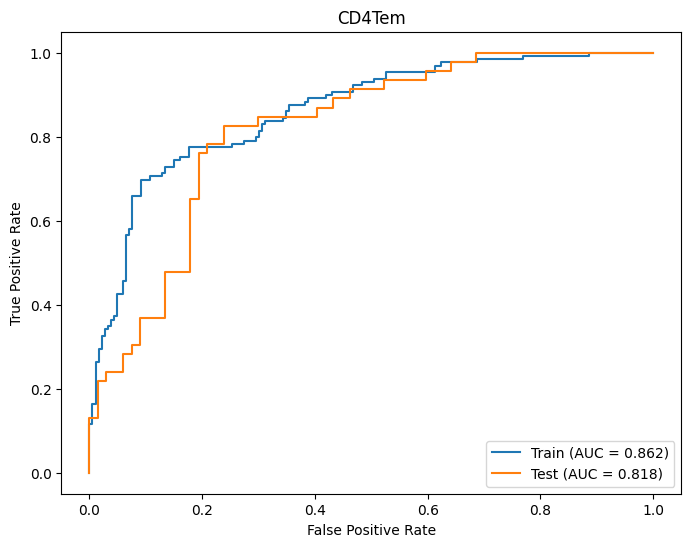

In [140]:
import matplotlib.pyplot as plt
from sklearn import metrics

# Plot ROC curves
plt.figure(figsize=(8, 6))

# ROC curve and AUC for training data
y_train_pred_proba = best_xgb.predict_proba(X_train)[:, 1]
train_auc = metrics.roc_auc_score(y_train, y_train_pred_proba)
metrics.RocCurveDisplay.from_estimator(
    best_xgb, X_train, y_train, ax=plt.gca(), 
    label=f"Train (AUC = {train_auc:.3f})"
)

# ROC curve and AUC for test data
y_test_pred_proba = best_xgb.predict_proba(X_test)[:, 1]
test_auc = metrics.roc_auc_score(y_test, y_test_pred_proba)
metrics.RocCurveDisplay.from_estimator(
    best_xgb, X_test, y_test, ax=plt.gca(), 
    label=f"Test (AUC = {test_auc:.3f})"
)

# Add title and labels
plt.title('CD4Tem')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig("roc-auc_cd4tem.png", bbox_inches="tight")
plt.show()

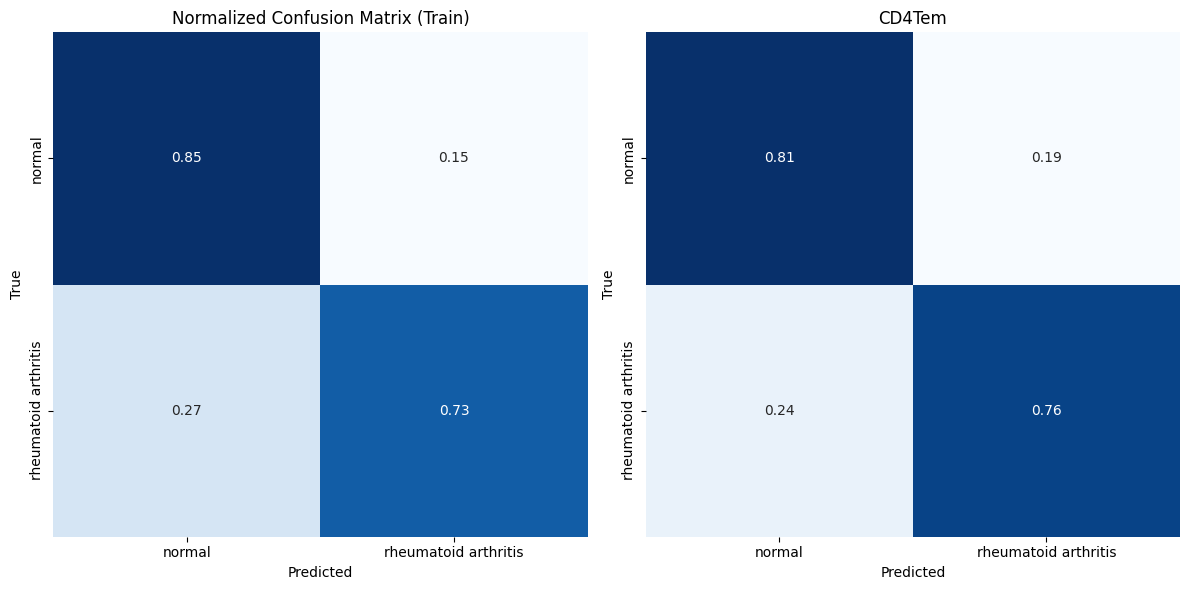

Train F1 Score: 0.7490
Test F1 Score: 0.7447
Train Accuracy: 0.8000
Test Accuracy: 0.7876
precision score:  0.7291666666666666
recall score:  0.7608695652173914


In [136]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions
y_train_pred = best_xgb.predict(X_train)
y_test_pred = best_xgb.predict(X_test)

# Compute confusion matrices
train_cm = confusion_matrix(y_train, y_train_pred)
test_cm = confusion_matrix(y_test, y_test_pred)
train_cm_normalized = train_cm.astype('float') / train_cm.sum(axis=1)[:, np.newaxis]
test_cm_normalized = test_cm.astype('float') / test_cm.sum(axis=1)[:, np.newaxis]


# Function to plot normalized confusion matrix

def plot_normalized_confusion_matrix(cm, title, class_names, ax):
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)

class_names = ['normal', 'rheumatoid arthritis']
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

plt.figure(figsize=(6, 6))  # Atur ukuran plot
plot_normalized_confusion_matrix(test_cm_normalized, title='CD4Tem', class_names=class_names, ax=plt.gca())
plt.tight_layout()  # Sesuaikan layout agar tidak terpotong
plt.savefig("CD4Tem_confusion matrix.png", bbox_inches="tight")  # Simpan sebagai PNG
plt.close()  # Tutup plot untuk mengosongkan memori

plot_normalized_confusion_matrix(train_cm_normalized, title='Normalized Confusion Matrix (Train)', class_names=class_names, ax=axes[0])
plot_normalized_confusion_matrix(test_cm_normalized, title='CD4Tem', class_names=class_names, ax=axes[1])

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

# Calculate F1 score for train and test sets
train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Train F1 Score: {train_f1:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("precision score: ", metrics.precision_score(y_test, best_xgb.predict(X_test)))
print("recall score: ", metrics.recall_score(y_test, best_xgb.predict(X_test)))

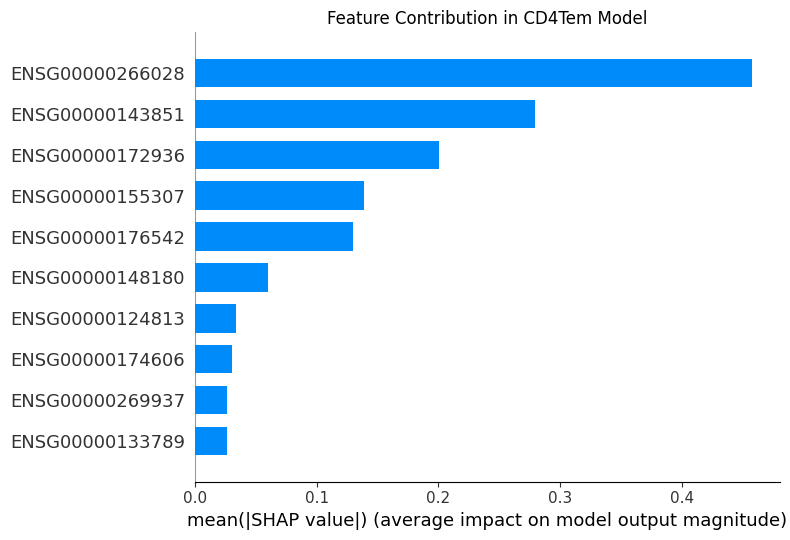

In [141]:
import shap

# SHAP analysis
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Plot 1: SHAP summary plot (bar)
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10, show=False)  # Atur ukuran plot
plt.title("Feature Contribution in CD4Tem Model")  # Tambahkan judul
plt.tight_layout()  # Sesuaikan layout agar judul tidak terpotong
plt.savefig("shap_summary_bar_cd4tem.png", bbox_inches="tight")  # Simpan sebagai PNG
#plt.close()  # Tutup plot untuk mengosongkan memori

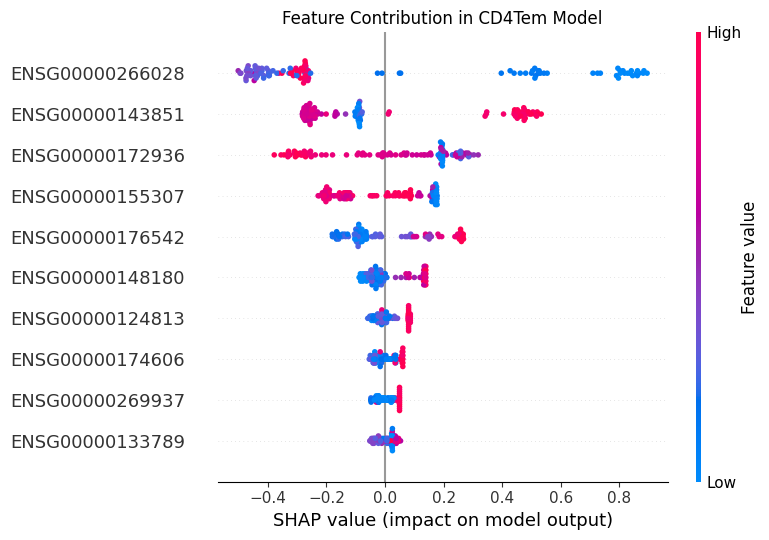

In [142]:
# Plot 2: SHAP summary plot (dot)
shap.summary_plot(shap_values, X_test, max_display=10, show=False)  # Atur ukuran plot
plt.title("Feature Contribution in CD4Tem Model")  # Tambahkan judul
plt.tight_layout()  # Sesuaikan layout agar judul tidak terpotong
plt.savefig("shap_summary_beeswarm_cd4tem.png", bbox_inches="tight")  # Simpan sebagai PNG
#plt.close()  # Tutup plot untuk mengosongkan memori

(101, 14)


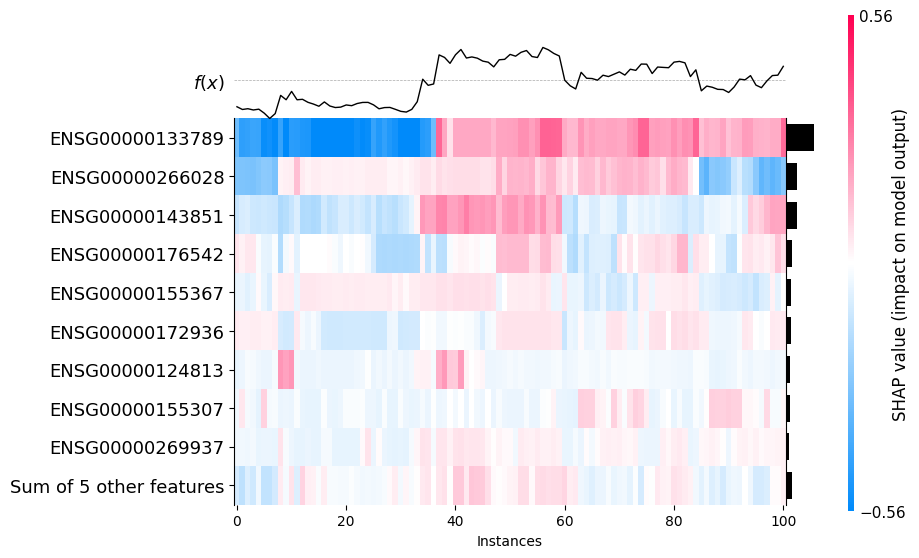

In [22]:
import shap
import numpy as np
import pandas as pd

# Assuming best_model is already trained and X_test is your test data
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

# Check the shape of shap_values
print(np.array(shap_values).shape)  # Should be (n_samples, n_features)

# Ensure X_test is a DataFrame with feature names
if not isinstance(X_test, pd.DataFrame):
    X_test = pd.DataFrame(X_test, columns=[f"feature_{i}" for i in range(X_test.shape[1])])

# Create the Explanation object
explanation = shap.Explanation(
    values=shap_values,  # SHAP values (2D array)
    base_values=explainer.expected_value,  # Base value (mean prediction)
    data=X_test,  # Feature values (as a DataFrame)
    feature_names=X_test.columns.tolist()  # Feature names
)

# Now you can use the explanation object to create the heatmap
shap.plots.heatmap(explanation)

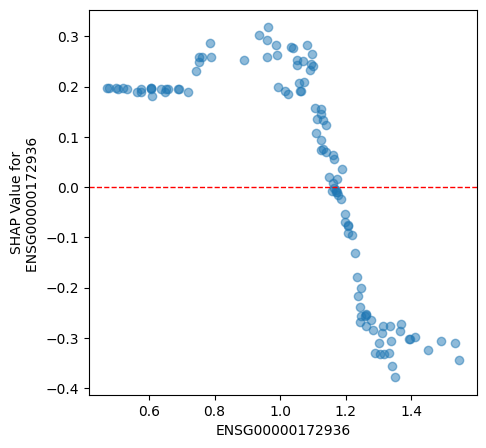

In [144]:
import matplotlib.pyplot as plt
import numpy as np

# Extract SHAP values and feature values for the specific feature
feature_name = "ENSG00000172936"
feature_index = list(X_test.columns).index(feature_name)  # Get the index of the feature
feature_values = X_test.iloc[:, feature_index]  # Feature values
shap_values_for_feature = shap_values[:, feature_index]  # SHAP values for the feature

# Create a color array: blue for SHAP < 0, pink for SHAP >= 0

#colors = np.where(shap_values_for_feature < 0, 'blue', '#ff084a')

# Create the scatter plot
plt.figure(figsize=(5, 5))
plt.scatter(feature_values, shap_values_for_feature, alpha=0.5)
plt.xlabel(feature_name)
plt.ylabel(f'SHAP Value for\n{feature_name} ')

# Add a dashed horizontal line at y=0
plt.axhline(0, color='red', linestyle='--', linewidth=1, label='y = 0')
#plt.axvline(1.5, color='red', linestyle='--', linewidth=1, label='x = 1.5')
# Show the plot
plt.savefig("shap_value_ENSG00000172936_cd4tem.png", bbox_inches="tight")
plt.show()